<a href="https://colab.research.google.com/github/lucinnnal/Segformer/blob/main/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install safetensors
from safetensors.torch import load_file
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import torch
from PIL import Image

# 모델과 프로세서 불러오기
model_name = "/content/drive/MyDrive/config (2).json"  # 모델 파일 경로 (config.json이 포함된 디렉토리)
processor = SegformerImageProcessor.from_pretrained("nvidia/mit-b0")
model_weights = load_file("/content/drive/MyDrive/model (1).safetensors")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
    config=model_name)
model.load_state_dict(model_weights)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inference 준비
model.eval()  # 모델을 평가 모드로 설정 (Dropout, BatchNorm 등을 비활성화)
model.to(device)  # 모델을 GPU로 이동 (혹은 CPU)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [7]:
# 이미지 불러오기
image = Image.open("/content/0550473_sc-107702.jpg").convert("RGB").resize((512, 512))  # 예시 이미지

# 이미지 전처리
inputs = processor(images=image, return_tensors="pt").to(device)

# Inference 수행
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # 모델의 출력 (예측된 logits)

# 출력 후 후처리 (예시: 예측된 클래스 레이블 얻기)
print(f"logit shape : {logits.shape}")
predictions = torch.argmax(logits, dim=1).squeeze(0)
print(f"after prediction and squeezing, segmap shape: {predictions.shape}")

logit shape : torch.Size([1, 2, 128, 128])
after prediction and squeezing, segmap shape: torch.Size([128, 128])


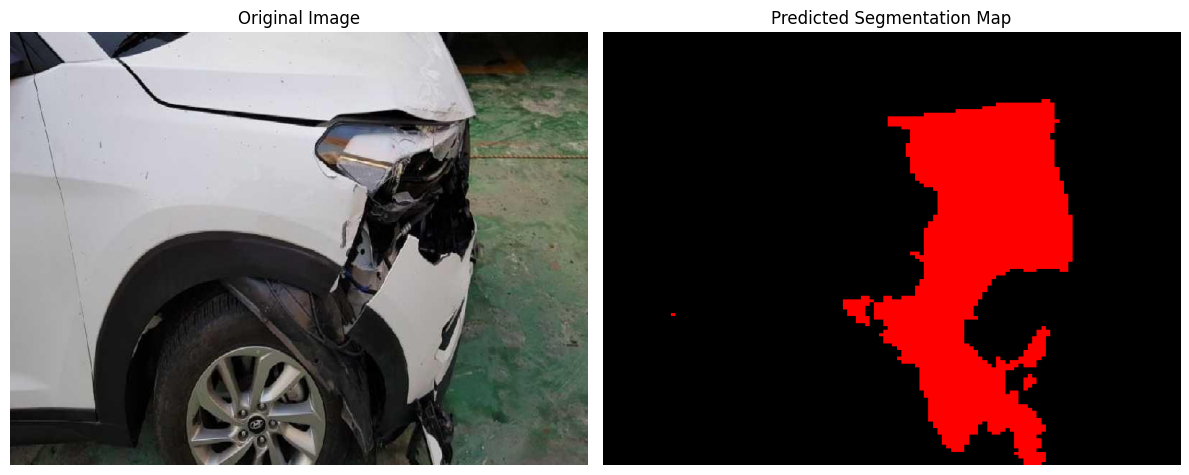

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # 이미지 로드를 위해 사용

# 클래스별 색상 정의
colors = [
    [0, 0, 0],      # Background
    [255, 0, 0]     # Damaged
]

# 예시: 원본 이미지 경로와 예측 맵 배열 (여기에 맞게 변경)
image_path = "/content/0550473_sc-107702.jpg"  # 원본 이미지 파일 경로

# 원본 이미지 로드
image = cv2.imread(image_path)  # OpenCV로 이미지 로드 (BGR 포맷)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환

# 세그멘테이션 맵을 색상으로 변환
colored_map = np.zeros((predictions.shape[0], predictions.shape[1], 3), dtype=np.uint8)
for class_id, color in enumerate(colors):
    colored_map[predictions == class_id] = color

# 세그멘테이션 맵 크기를 원본 이미지 크기로 조정
colored_map_resized = cv2.resize(colored_map, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# 이미지와 세그멘테이션 맵을 나란히 시각화
plt.figure(figsize=(12, 12))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# 세그멘테이션 맵
plt.subplot(1, 2, 2)
plt.imshow(colored_map_resized)
plt.title("Predicted Segmentation Map")
plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
predictions.shape

torch.Size([128, 128])